---
# AmpliGraph Tutorial 1
---
In this tutorial we will demonstrate how to use the AmpliGraph library. 

Things we will cover:

1. Exploration of a graph dataset
2. Splitting graph datasets into train and test sets
3. Training a model
4. Model selection and hyper-parameter search 
5. Saving and restoring a model
6. Evaluating a model
7. Using link prediction to discover unknown relations
8. Visualizing embeddings using Tensorboard

---

### Requirements:

A python environment with the AmpliGraph library installed. Please follow [the install guide](http://docs.ampligraph.org/en/latest/install.html).

In addition, you may want to install matplotlib and networkx to run some graph visualization code:

    pip install matplotlib networkx 

---


# 1. Dataset exploration

First things first! Lets import the required libraries and retrieve some data:

In [1]:
import ampligraph
import numpy as np
import pandas as pd

In this tutorial we're going to use the **`Nations`** graph dataset. Please note: this isn't the *greatest* dataset for demonstrating the power of knowledge graph embeddings, but is small, intuitive and should be familiar to most users. 

Run the following cell to pull down the dataset:

In [2]:
import io 
from zipfile import ZipFile
from urllib.request import urlopen

nations = pd.DataFrame()

resp = urlopen('https://s3-eu-west-1.amazonaws.com/ampligraph/datasets/nations.zip')
zipfile = ZipFile(io.BytesIO(resp.read()))
for fname in ['train', 'test', 'valid']:
    tmp = []
    for line in zipfile.open('nations/%s.txt' % fname).readlines():
        tmp.append(line.decode('utf-8'))
    
    nations = nations.append(pd.read_csv(io.StringIO('\n'.join(tmp)), delim_whitespace=True, header=None))

nations.columns = ['subject', 'predicate', 'object']
nations.reset_index(inplace=True, drop=True)

Each data point is an triple in the form: 

    <subject, predicate, object>


In [3]:
nations.head(10)

,subject,predicate,object
0,netherlands,militaryalliance,uk
1,egypt,intergovorgs3,usa
2,jordan,relbooktranslations,usa
3,poland,timesincewar,ussr
4,uk,negativebehavior,ussr
5,poland,relintergovorgs,uk
6,usa,weightedunvote,india
7,china,accusation,india
8,uk,unweightedunvote,egypt
9,poland,embassy,netherlands


Let's list the subject and object entities found in the dataset:

In [4]:
entities = np.concatenate([nations['subject'], nations['object']])
print(np.unique(entities))

['brazil' 'burma' 'china' 'cuba' 'egypt' 'india' 'indonesia' 'israel'
 'jordan' 'netherlands' 'poland' 'uk' 'usa' 'ussr']


.. and all of the relationships that link them. Remember, these relationships only link *some* of the entities.

In [5]:
relations = nations['predicate']
print(relations.unique())

['militaryalliance' 'intergovorgs3' 'relbooktranslations' 'timesincewar'
 'negativebehavior' 'relintergovorgs' 'weightedunvote' 'accusation'
 'unweightedunvote' 'embassy' 'commonbloc1' 'commonbloc2' 'ngoorgs3'
 'exports3' 'economicaid' 'booktranslations' 'relexports' 'intergovorgs'
 'independence' 'reltreaties' 'ngo' 'blockpositionindex' 'relstudents'
 'aidenemy' 'eemigrants' 'officialvisits' 'unoffialacts' 'releconomicaid'
 'commonbloc0' 'expeldiplomats' 'relngo' 'students' 'nonviolentbehavior'
 'reldiplomacy' 'tourism' 'timesinceally' 'conferences' 'relexportbooks'
 'treaties' 'militaryactions' 'exportbooks' 'boycottembargo'
 'negativecomm' 'tourism3' 'reltourism' 'pprotests' 'emigrants3'
 'duration' 'attackembassy' 'dependent' 'violentactions' 'relemigrants'
 'warning' 'lostterritory' 'severdiplomatic']


## Visualizing graph data with NetworkX 

When working with graphs it's often useful (and even required) to visualize the data. Here, we're going to use the excellent [networkx](https://networkx.github.io/) library to display some of the relations found in our dataset. If you haven't installed NetworkX, or aren't interesting in generating visualizations right now then feel free to skip this section - it won't affect the rest of the tutorial. 

C:\Users\nicholas.mccarthy\miniconda3\envs\ampligraph\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


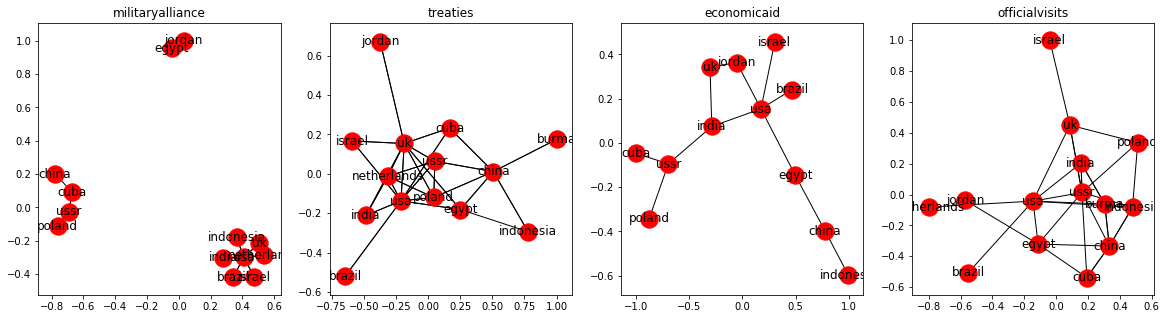

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for index, relation in enumerate(['militaryalliance', 'treaties', 'economicaid', 'officialvisits']):

    G = nx.MultiGraph()
    for i, row in nations.loc[nations['predicate'] == relation].iterrows():
        G.add_nodes_from([row[0], row[2]])
        G.add_edge(row[0], row[2], name=row[1])

    axs[index].set_title(relation)
    nx.draw_networkx(G, ax=axs[index])

# 2. Defining train and test datasets

As is typical in machine learning, we need to split our dataset into training and test (and sometimes validation) datasets. What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least 1 triple. To accomplish AmpliGraph provides the `train_test_split_no_unseen` function. 

We'll stick to common practice and divide our training and test set in an 80/20 split. 

In [7]:
from ampligraph.evaluation import train_test_split_no_unseen 

num_test = int(len(nations) * (20 / 100))

data = {}
data['train'], data['test'] = train_test_split_no_unseen(nations.values, test_size=num_test, seed=0, allow_duplication=False) 

Our data is now split into train/test sets. If we need to further divide into a validation dataset we can just repeat using the same procedure on the test set (and adjusting the split percentages). 

In [8]:
print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)

Train set size:  (1594, 3)
Test set size:  (398, 3)


---
# 3. Training a model 

AmpliGraph has implemented several Graph embedding models (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the ComplEx model (with  default values), so lets import that:

In [9]:
from ampligraph.latent_features import ComplEx

Lets go through the parameters to understand what's going on:

- **`k`** : the dimensionality of the embedding space
- **`eta`** ($\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple
- **`batches_count`** : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- **`epochs`** : the number of epochs to train the model for.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-3 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=2$, i.e. l2 regularization. $\lambda$ = 1e-5, set via the *regularizer_params* kwarg. 

Now we can instantiate the model:


In [10]:
model = ComplEx(batches_count=10, 
                seed=0, 
                epochs=200, 
                k=20, 
                eta=10,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='pairwise', 
                loss_params={'margin':0.5},
                regularizer='LP', 
                regularizer_params={'p':2, 'lambda':1e-5}, 
                verbose=True)

## Filtering negatives

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions. 

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no *negative* statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.  


In [11]:
positives_filter = np.concatenate((data['train'], data['test']))    

## Early stopping

We're also going to use early stopping to ensure we don't waste our valuable time (or GPU resources!). 

To train with early stopping we typically need a validation set, so let's revisit the `train_test_split_no_unseen` function from before, and divide the current test set in half to obtain a test and validation set. 

In [12]:
num_valid = len(data['test']) // 2
data['test'], data['valid'] = train_test_split_no_unseen(data['test'], test_size=num_valid, seed=0)

Let's take a look at some of the early stopping parameters:

- **`x_valid`** - specifies our validation set, so that we can test model performance on data we're not training on and stop at a good point
- **`criteria`** - the metric we'll use to measure model performance on the validation set. We specify here the 'hits10' criteria, which measures the amount of times the positive sample is found in the top 10 closest values when performing link prediction #TODO: Check this text
- **`burn_in`** - allows the model to train for a few epochs before early stopping kicks in
- **`check_interval`** - specifies how often the validation set should be evaluated for early stopping. 
- **`stop_interval`** - specifies how many validation set evaluations must be bad for early stopping to kick in. 
- **`x_filter`** - specifies the filter used to filter out the positives (we defined this above)
- **`corruption_entities`** - specifies the corruption strategy. Here we specify 'all' so corruptions are generated using all of the entitites.
- **`corrupt_side`** - specifies which end of the triple should be used for corruptions. Here we specify 's+o', so both subject and object are used for corruptions, but now at the same time.

Based on the burn_in, check_interval and stop_interval values we can see that the model will train for at least **n** epochs, where

    n = burn_in + (stop_interval * check_interval)  

In [13]:
early_stopping_params = { 'x_valid': data['valid'],    
                         'criteria':'hits10',
                         'burn_in': 100,
                         'check_interval':5,
                         'stop_interval':3,
                         'x_filter': positives_filter, 
                         'corruption_entities':'all',  
                         'corrupt_side':'s+o'          
                        }

We should now have a **`train`**, **`test`** and **`valid`** set, in an 80/10/10 split:


In [14]:
print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)
print('Valid set size: ', data['valid'].shape)

Train set size:  (1594, 3)
Test set size:  (199, 3)
Valid set size:  (199, 3)


## Fitting the model

Once you run the next cell the model will train. 

On the **`Nations`** dataset this shouldn't take too long: on an i7 CPU this was taking ~10secs before reaching early stopping, although your mileage may vary, especially if you've changed any of the parameters above. 

In [15]:
# Fit the model on training and validation set
model.fit(data['train'], 
          early_stopping = True,
          early_stopping_params = early_stopping_params
         )


WARNING - From C:\Users\nicholas.mccarthy\miniconda3\envs\ampligraph\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From C:\Users\nicholas.mccarthy\miniconda3\envs\ampligraph\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Average Loss:   0.256606:  56%|█████▋    | 113/200 [00:05<00:05, 16.69epoch/s]


---
# 4. Model selection and hyper-parameter search 

The AmpliGraph team has run extensive hyperparameter searches to determine the best default values for each model on a range of datasets, but as there is [no free lunch](https://en.wikipedia.org/wiki/No_free_lunch_theorem), in most specific cases you'll want to search for the best parameters for your model. Let's cover how to do that in AmpliGraph. 

To begin, import the `select_best_model_ranking` function. 


In [18]:
from ampligraph.evaluation import select_best_model_ranking

This function only supports selection over a single model class - easily extended in a simple list of classes - but for now let's just continue to work with the **`ComplEx`** model. 

In [19]:
from ampligraph.latent_features import ComplEx

model_class = ComplEx

## Parameter grid

This function runs a grid search over defined parameters, so let's define our parameters in the **`param_grid`** dict. 

All of the parameters here have already been discussed in Section 3 (Training a model), the only difference is that here we provide a list of possible values to search over. Don't worry that some of the parameters only apply to certain classes or loss functions - we take care of mapping the params to the corresponding classes. 



In [20]:
param_grid = {
    "batches_count": [10],
    "seed": 0,
    "epochs": [100],
    "k": [10, 20],
    "eta": [5,10],
    "loss": ["pairwise", "nll"],
    "loss_params": {
        "margin": [0.5] 
    },
    "embedding_model_params": {
        # generate corruption using all entities during training
        "negative_corruption_entities":"all"
    },
    "regularizer": [None, "LP"],
        "regularizer_params": {
        "p": [2],
        "lambda": [1e-4, 1e-5]
    },
    "optimizer": ["adam"],
    "optimizer_params":{
        "lr": [0.01, 0.001]
    },
    # 
    "verbose": False
}


## Select best model

Now that we've defined the parameters to search, let's run the `select_best_model_ranking` function using our **`model_class`**. 

The input parameters for this function are: 

- **`model_class`** - the class of the model to use - defined above.
- **`X`** - a dictionary of datasets: `train`, `test`, and `valid`. 
- **`params_grid`** - the grid of hyperparameters to search - defined above.
- **`use_filter`** - a bool indicating whether to use the entire input dataset X to compute filtered MRR. 
- **`early_stopping`** - a bool indicating whether to use early stopping - we won't use that here. 
- **`early_stopping_params`** - early stopping parameters - already covered above. 
- **`use_test_for_selection `** - use test set for model selection (false uses validation set)
- **`rank_against_ent `** - list of entities to use for corruptions. The default (None) will generate corruptions using all distinct entities.  
- **`corrupt_side `** - which side of the triples to corrupt entities. **`'s'`** corrupts only subject, **`'o'`** corrupts only object, **`'s+o'`** corrupts both. 
- **`use_default_protocol `** - a bool indicating whether to evaluate head and tail corruptions separately. If True, will  ignore the `corrupt_side` argument and corrupt head and tail separately. 
- **`verbose`** - use verbose mode during evaluation of trained model.

Running the next cell may take a while, so you might want to go and grab a coffee 

In [21]:
best_model, best_params, best_mrr_train, ranks_test, mrr_test = select_best_model_ranking(model_class,
                                                                                          X=data, 
                                                                                          param_grid=param_grid, 
                                                                                          use_filter=True,
                                                                                          use_default_protocol=True, 
                                                                                          verbose=False)

WARNING - From c:\users\nicholas.mccarthy\projects\ampligraph\ampligraph\ampligraph\evaluation\protocol.py:396: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.random.categorical instead.


Now let's take a look at the output of `select_best_model_ranking`:

- **`best_model`** - an instance of the best model found in the search. 
- **`best_params`** - a dict of the hyperparameters of the best model 
- **`best_mrr_train`** - the MRR (unfiltered) of the **`best_model`** computed over the validation set 
- **`ranks_test`** - the ranks of each triple in the test set for the **`best_model`**
- **`mrr_test`**  - the MRR (filtered) of the **`best_model`**, re-trained on the concatenation of train and valid datasets, computed on the test set. 


In [36]:
print('Best model parameters found:')

for k,v in best_params.items():
    print('\t %s: %s' % (k,v))


Best model parameters found:
	 batches_count: 10
	 epochs: 1
	 k: 10
	 eta: 5
	 loss: nll
	 loss_params: {}
	 embedding_model_params: {'negative_corruption_entities': 'a'}
	 regularizer: LP
	 regularizer_params: {'p': 2, 'lambda': 0.0001}
	 optimizer: adam
	 optimizer_params: {'lr': 0.01}
	 verbose: False
	 seed: 0


---
# 5.  Saving and restoring a model

Before we go any further, let's save the best model found so that we can restore it in future.

In [38]:
from ampligraph.latent_features import save_model, restore_model

This will save the model in the ampligraph_tutorial directory as *model.pickle*.

In [39]:
save_model(best_model, './best_model.pkl')

.. we can then delete the model .. 

In [40]:
del model

.. and then restore it from disk! Ta-da! 

In [41]:
model = restore_model('./best_model.pkl')

And let's just double check that the model we restored has been fit:

In [42]:
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


---
# 6. Evaluating a model

Now it's time to evaluate our model on the test set to see how well it's performing. 

For this we'll use the `evaluate_performance` function:

In [51]:
from ampligraph.evaluation import evaluate_performance

And let's look at the arguments to this function:

- **`X`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`model`** - the model we previously trained.
- **`filter_triples`** - will filter out the false negatives generated by the corruption strategy. 
- **`use_default_protocol`** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - will give some nice log statements. Let's leave it on for now.


## Running evaluation

In [69]:
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

100%|██████████| 199/199 [00:00<00:00, 251.62it/s]



The ***ranks*** returned by the evaluate_performance function indicate the rank at which the test set triple was found when performing link prediction using the model. 

For example, given the triple:

    <cuba, independence, usa> 
    
The model may return a rank of 2. This tells us that while it's not the highest likelihood true statement (which would be given a rank of 1), it's pretty likely.


## Metrics

Let's compute some evaluate metrics and print them out.

We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions. 

- ***mrr_score***:  The function computes the mean of the reciprocal of elements of a vector of rankings ranks.
- ***hits_at_n_score***: The function computes how many elements of a vector of rankings ranks make it to the top n positions.


In [70]:
from ampligraph.evaluation import mrr_score, hits_at_n_score

mrr = mrr_score(ranks)

print("MRR: %f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %f" % (hits_10))

MRR: 0.374746
Hits@10: 0.937186


---
# 7. Performing link prediction

Link prediction allows us to infer missing links in a graph. This has many real-world use cases, such as predicting connections between people in a social network, interactions between proteins in a biological network, and music recommendation based on prior user taste. 

In our case, we're going to see which of the following statements are more likely to be true:


In [71]:
unseen_triples = np.array([['ussr', 'militaryalliance', 'usa'], 
                           ['usa', 'militaryalliance', 'ussr'], 
                           ['usa', 'boycottembargo', 'cuba'],
                           ['ussr', 'attackembassy', 'cuba'],
                           ['usa', 'militaryalliance', 'cuba'], 
                           ['usa', 'attackembassy', 'burma']])

Because our dataset here is a very small graph, there aren't actually all that many missing links 

Before predicting, let's make sure that our model wasn't trained on these statements. 

In [72]:
for new_triple in unseen_triples:
    for train_triple in data['train']:
        if np.all(train_triple == new_triple):
            print('Machine learning? More like machine cheating!')

Now lets make our predictions:

In [73]:
predictions = model.predict(unseen_triples)

.. and print them out. 

In [74]:
for triple, y in zip(unseen_triples, predictions):
    print(triple, 'score: %0.2f' % y)

['ussr' 'militaryalliance' 'usa'] score: 0.08
['usa' 'militaryalliance' 'ussr'] score: 0.06
['usa' 'boycottembargo' 'cuba'] score: 0.08
['ussr' 'attackembassy' 'cuba'] score: -0.01
['usa' 'militaryalliance' 'cuba'] score: 0.06
['usa' 'attackembassy' 'burma'] score: 0.05


---
# 8. Visualizing with Tensorboard projector 

The kind folks at Google have created Tensorboard, which allows us to graph how our model is learning (or .. not :|), peer into the innards of neural networks, and visualize high-dimensional embeddings in the browser.   

Lets import the `create_tensorboard_visualization` function, which simplifies the creation of the files necessary for Tensorboard to display the embeddings.

In [75]:
from ampligraph.utils import create_tensorboard_visualizations

And now we'll run the function with our model, specifying the output path:

In [77]:
create_tensorboard_visualizations(model, './visualizations')

If all went well, we should now have a number of files in the *'AmpliGraph/tutorials/visualizations/'* directory:

- checkpoint
- metadata.tsv
- projector_config.pbtxt
- .. and a number of graph_embedding.ckpt.* files 

To visualize the embeddings in Tensorboard, run the following from your command line in the *ampligraph_tutorial* directory.

    tensorboard --logdir=./visualizations
    
    
.. and once your browser opens up you should be able to see and explore your embeddings as below. 

![title](tensorboard_graph_example.png)


---
# The End

You made it to the end! Well done!

For more information please visit the [AmpliGraph GitHub](github.com/Accenture/AmpliGraph) (and remember to star the project!), or check out the [documentation](docs.ampligraph.org) 

---
